<a href="https://colab.research.google.com/github/Bhuvanachandra-kusuma/MEMRISTOR-CROSSBAR-VMM-SIMULATION-PYTHON/blob/main/MEMRISTOR_CROSSBAR_VMM_SIMULATION_%E2%80%94_PYTHON_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                 # NumPy is used for matrix operations & numerical computations
import matplotlib.pyplot as plt    # Matplotlib is used for plotting graphs and visualizations

MEMRISTOR DEVICE MODEL

In [ ]:
class Memristor:
    """
    This class represents a single memristor device using a simplified
    nonlinear drift model based on the classic HP memristor concept.

    The internal state 'w' controls the resistance:
        - When w → D, device behaves like low resistance Ron
        - When w → 0, device behaves like high resistance Roff
    """
    def __init__(self, Ron=100, Roff=16000, D=10e-9, mu=1e-14, dt=1e-6):
        # Ron: low resistance state (conductive)
        # Roff: high resistance state (non-conductive)
        # D: device thickness in meters
        # mu: mobility constant
        # dt: time step for numerical integration

        self.Ron = Ron
        self.Roff = Roff
        self.D = D
        self.mu = mu
        self.dt = dt

        # Initialize internal state w randomly between 20% and 80% of device thickness
        # This mimics random fabrication variation
        self.w = np.random.uniform(0.2, 0.8) * D

    def update(self, V):
        """
        Update the internal state 'w' based on applied voltage V.
        dw/dt = μ * (Ron/D) * V

        Positive voltage → increases w (becomes more conductive)
        Negative voltage → decreases w (becomes less conductive)
        """
        dw = self.mu * (self.Ron / self.D) * V * self.dt

        # Update internal state
        self.w += dw

        # Clamp w between 0 and D to prevent invalid values
        self.w = np.clip(self.w, 0, self.D)

    def get_conductance(self):
        """
        Calculate conductance based on current state.
        Conductance G = 1 / R

        R(w) = Ron*(w/D) + Roff*(1 - w/D)
        """
        R = self.Ron * (self.w / self.D) + self.Roff * (1 - self.w / self.D)
        return 1 / R

CREATE A MATRIC (CROSSBAR) OF MEMRISTORS

In [ ]:
def create_crossbar(rows, cols):
    """
    Creates a 2D matrix (rows x cols) of memristor objects.
    """
    return [[Memristor() for _ in range(cols)] for _ in range(rows)]

PROGRAM THE CROSSBAR TO MATCH A WEIGHT MATRIX

In [ ]:
def program_crossbar(crossbar, weight_matrix):
    """
    Programs each memristor's state based on the target weight matrix.

    High weight → higher conductance → larger state 'w'
    Low weight → lower conductance → smaller 'w'
    """
    rows = len(crossbar)
    cols = len(crossbar[0])

    # Normalize target weights to the range [0, 1]
    w_norm = (weight_matrix - weight_matrix.min()) / (weight_matrix.max() - weight_matrix.min())

    # Set memristor internal state to match normalized weights
    for i in range(rows):
        for j in range(cols):
            crossbar[i][j].w = crossbar[i][j].D * w_norm[i, j]

PERFORM ANALOG VECTOR-MATRIX MULTIPLICATION (VMM)

In [ ]:
def crossbar_vmm(crossbar, input_vector, noise_std=0.0, variability=0.0):
    """
    Performs analog VMM:
        output = G_matrix × input_vector

    where G_matrix contains memristor conductances.

    noise_std: Gaussian noise added to mimic analog circuits
    variability: device variability to mimic fabrication imperfections
    """
    rows = len(crossbar)
    cols = len(crossbar[0])

    # Create empty conductance matrix
    G = np.zeros((rows, cols))

    # Fill G with memristor conductances
    for i in range(rows):
        for j in range(cols):
            g = crossbar[i][j].get_conductance()

            # Add device variability (5% → 0.05)
            g *= (1 + np.random.normal(0, variability))

            G[i][j] = g

    # Analog VMM (dot product)
    analog_output = G @ input_vector

    # Add analog noise (simulating wire noise / thermal noise)
    analog_output += np.random.normal(0, noise_std, size=analog_output.shape)

    return analog_output, G

RUN SIMULATION

In [ ]:
# Set crossbar size
rows, cols = 4, 4

# Create a random weight matrix
W = np.random.uniform(0.1, 1.0, size=(rows, cols))

# Create the memristor crossbar
crossbar = create_crossbar(rows, cols)

# Program memristors with desired weights
program_crossbar(crossbar, W)

# Generate a random input vector
x = np.random.uniform(0.1, 1.0, size=(cols,))

# Compute ideal output digitally
ideal_output = W @ x

# Compute analog memristor output
analog_output, G_matrix = crossbar_vmm(
    crossbar,
    x,
    noise_std=0.01,     # small noise added
    variability=0.05     # 5% device variability
)


VISUALIZATION


Input Vector x:
 [0.57848112 0.26219968 0.44291217 0.17472057]

Ideal Output (W * x):
 [1.01831487 0.860447   0.69260876 0.85427584]

Analog Memristor Output:
 [ 0.02542208  0.01493584 -0.00484892  0.01357882]

Error (Analog - Ideal):
 [-0.99289279 -0.84551116 -0.69745769 -0.84069702]


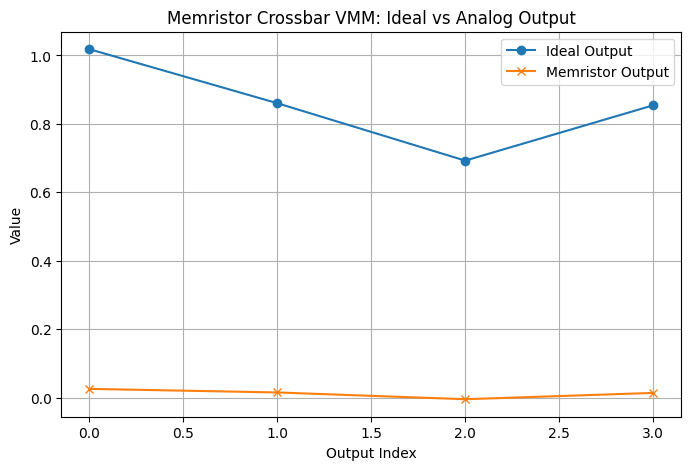

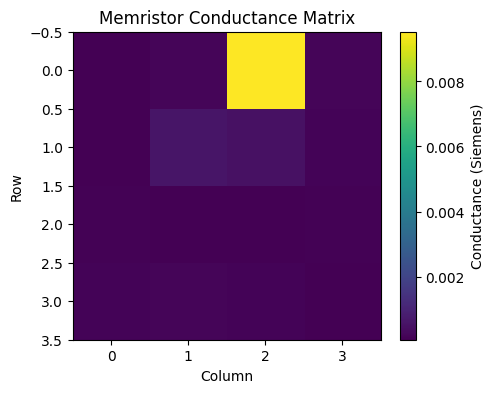

In [ ]:
print("\nInput Vector x:\n", x)
print("\nIdeal Output (W * x):\n", ideal_output)
print("\nAnalog Memristor Output:\n", analog_output)
print("\nError (Analog - Ideal):\n", analog_output - ideal_output)

# Plot ideal vs analog output
plt.figure(figsize=(8, 5))
plt.plot(ideal_output, label="Ideal Output", marker='o')
plt.plot(analog_output, label="Memristor Output", marker='x')
plt.title("Memristor Crossbar VMM: Ideal vs Analog Output")
plt.xlabel("Output Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

# Heatmap of conductance matrix
plt.figure(figsize=(5,4))
plt.imshow(G_matrix, cmap="viridis")
plt.colorbar(label="Conductance (Siemens)")
plt.title("Memristor Conductance Matrix")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()